# Clip From Scratch #

In [1]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import DistilBertTokenizer, DistilBertModel
from timm import create_model
from torchvision import transforms
import pandas as pd
from torch import nn
import os
import matplotlib.pyplot as plt
from PIL import Image
from timm import create_model
from torchinfo import summary
import itertools
from tqdm import tqdm

c:\Users\DHRUV\anaconda3\envs\image\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv(r"C:\Users\DHRUV\.cache\kagglehub\datasets\adityajn105\flickr8k\versions\1\captions.txt")
df.head(10)

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   
5  1001773457_577c3a7d70.jpg   
6  1001773457_577c3a7d70.jpg   
7  1001773457_577c3a7d70.jpg   
8  1001773457_577c3a7d70.jpg   
9  1001773457_577c3a7d70.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  
5         A black dog and a spotted dog are fighting  
6  A black dog and a tri-colored dog playing with...  
7  A black dog and a white dog with brown spots a...  
8  Two dogs of different breeds looking at each o...  
9    Two dogs on pavement moving toward each other .

In [3]:
class CFG:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image_embeding = 2048
    text_model = "distilbert/distilbert-base-uncased"
    image_model = "resnet50"
    text_embeding = 768
    max_length = 200
    temperature = 1.0
    num_proj_layers = 1
    size = 224
    project_dim = 256
    dropout = 0.1

In [4]:
class ClipDataset(Dataset):
    def __init__(self) -> None:
        super().__init__()
        self.df = df
        self.image_folder = r"C:\Users\DHRUV\.cache\kagglehub\datasets\adityajn105\flickr8k\versions\1\Images"
        self.transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224,224)),
            transforms.Normalize(mean = [0.5,0.5,0.5],std = [0.5,0.5,0.5])
        ])

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.image_folder,self.df["image"][index]) # type: ignore
        caption = self.df["caption"][index]

        image = Image.open(img_path)
        image = self.transforms(image)
        image = torch.clip(image,0,1) # type: ignore

        return image, caption

In [5]:
dataset = DataLoader(ClipDataset(),batch_size=32,shuffle=True)

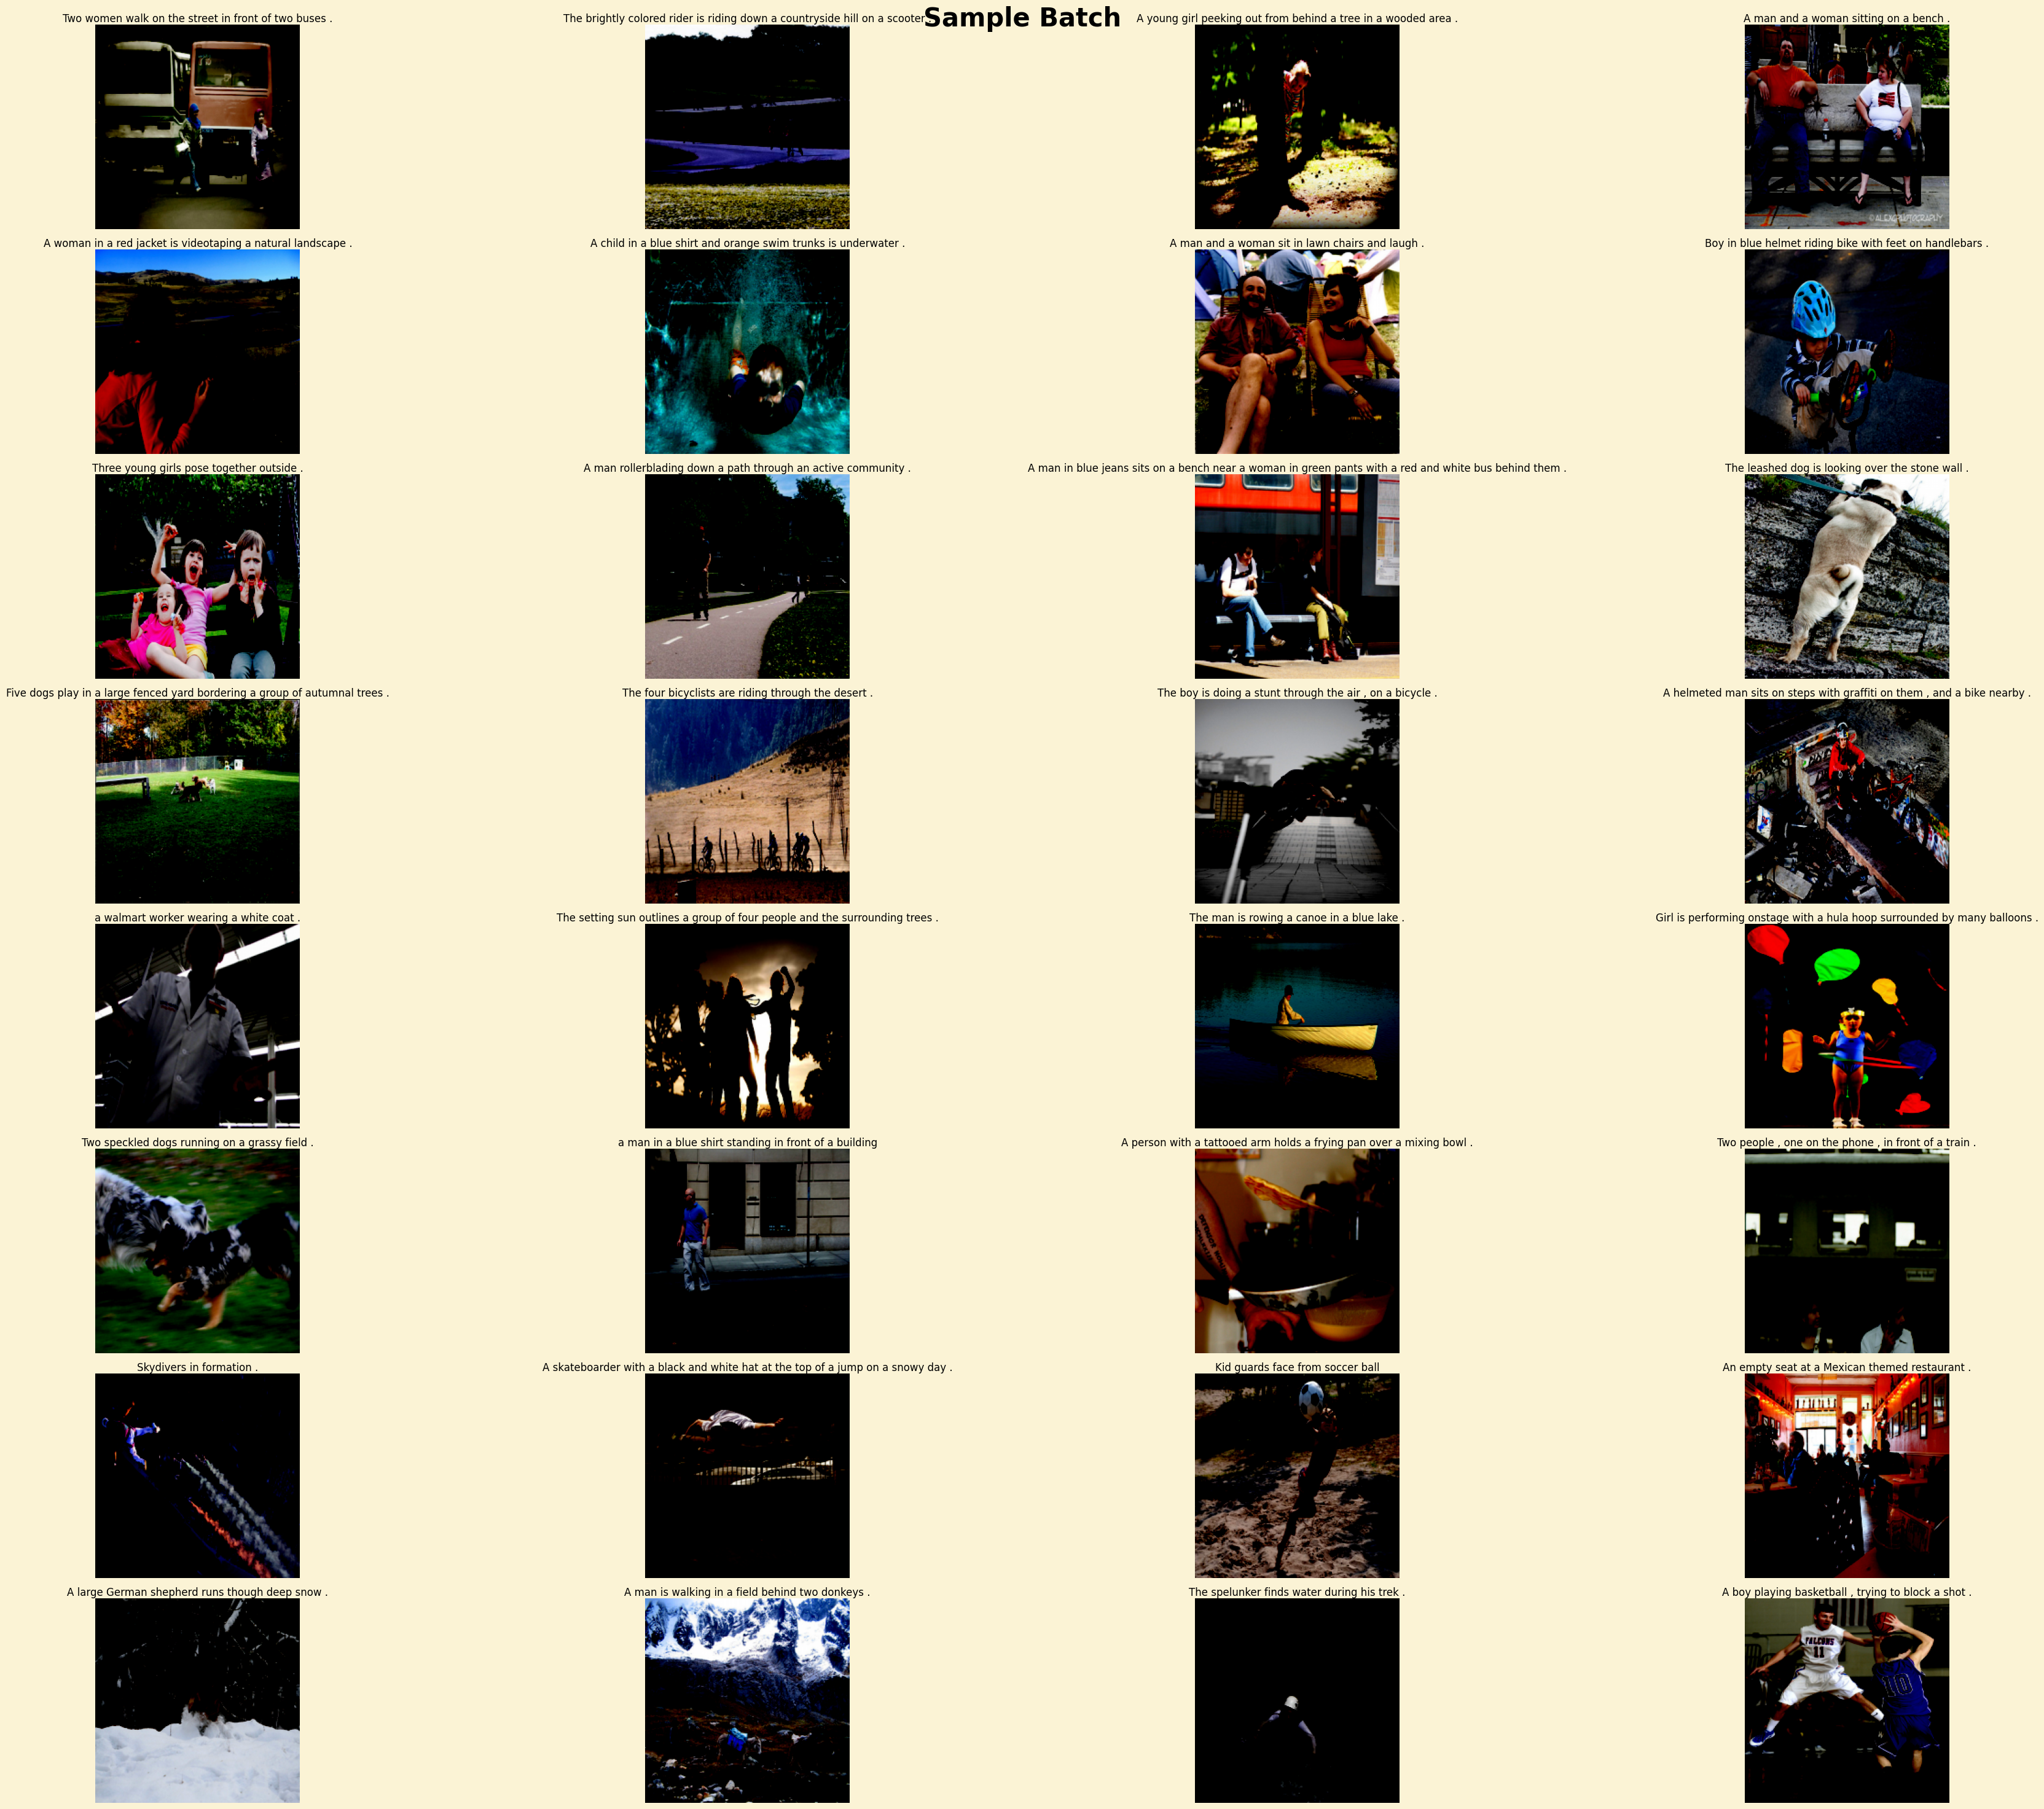

In [6]:
fig,axes = plt.subplots(8,4,figsize = (40,30))
axes = axes.flatten()
fig.suptitle("Sample Batch", fontsize = 30, fontweight = "bold")
fig.set_facecolor("#FBF3D5")
images,caption = next(iter(dataset))

for ind in range(32):
    ax = axes[ind]
    img = images[ind].detach().cpu().numpy().transpose(1,2,0)
    cap = caption[ind]
    ax.axis(False)
    ax.imshow(img)
    ax.set_title(cap, fontsize = 12,pad = 2)

fig.subplots_adjust(top = 0.95)
plt.tight_layout()
plt.show()

In [7]:
data = ClipDataset()
train_data, validation_data, test_data = random_split(data,[0.7,0.25,0.05]) # type: ignore
train_dataset = DataLoader(train_data,batch_size=32,shuffle=True)
validation_dataset = DataLoader(validation_data, batch_size=32,shuffle=True)
test_dataset = DataLoader(test_data, batch_size=32,shuffle=True)

In [8]:
next(iter(test_dataset))

[tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           ...,
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00]],
 
          [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           ...,
           [0.0000e+00, 0.0000e+00, 0.

In [9]:
print(len(dataset))
print(len(train_dataset))
print(len(validation_dataset))
print(len(test_dataset))

1265
885
317
64


In [10]:
class TextEmbeder(nn.Module):
    def __init__(self,CFG, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.model = DistilBertModel.from_pretrained(CFG.text_model)

    def forward(self,input_ids,attention_mask):
        if input_ids.dtype != torch.long and attention_mask.dtype != torch.long:
            input_ids = input_ids.type(torch.long)
            attention_mask = attention_mask.type(torch.long)
        with torch.no_grad():
            output = self.model(input_ids = input_ids, attention_mask = attention_mask)
        
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:,0,:]

In [11]:
model = TextEmbeder(CFG)
summary(model,[(1,10),(1,10)])
del(model)

In [12]:
class Image_Encoder(nn.Module):
    def __init__(self,CFG, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.resnet = create_model(CFG.image_model,pretrained=True,num_classes = 0, global_pool = "avg")

    def forward(self,image):
        with torch.no_grad():
            return self.resnet(image)

In [13]:
model = Image_Encoder(CFG)
print(summary(model,(32,3,224,224)))
del(model)

Layer (type:depth-idx)                        Output Shape              Param #
Image_Encoder                                 [32, 2048]                --
├─ResNet: 1-1                                 [32, 2048]                --
│    └─Conv2d: 2-1                            [32, 64, 112, 112]        9,408
│    └─BatchNorm2d: 2-2                       [32, 64, 112, 112]        128
│    └─ReLU: 2-3                              [32, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                         [32, 64, 56, 56]          --
│    └─Sequential: 2-5                        [32, 256, 56, 56]         --
│    │    └─Bottleneck: 3-1                   [32, 256, 56, 56]         75,008
│    │    └─Bottleneck: 3-2                   [32, 256, 56, 56]         70,400
│    │    └─Bottleneck: 3-3                   [32, 256, 56, 56]         70,400
│    └─Sequential: 2-6                        [32, 512, 28, 28]         --
│    │    └─Bottleneck: 3-4                   [32, 512, 28, 28]         379,392

In [14]:
class ProjectionHead(nn.Module):
    def __init__(self,embeding_dim,CFG, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear1 = nn.Linear(embeding_dim,CFG.project_dim)
        self.linear2 = nn.Linear(CFG.project_dim,CFG.project_dim)
        self.dropout = nn.Dropout(CFG.dropout)
        self.layernorm = nn.LayerNorm(CFG.project_dim)
        self.gelu = nn.GELU()
    
    def forward(self, x):
        proj = self.linear1(x)
        x = self.gelu(proj)
        x = self.linear2(x)
        x = self.dropout(x)

        x = proj + x
        return self.layernorm(x)

In [15]:
model = ProjectionHead(embeding_dim=CFG.image_embeding,CFG = CFG)
print(summary(model,(32,2048)))
del(model)

Layer (type:depth-idx)                   Output Shape              Param #
ProjectionHead                           [32, 256]                 --
├─Linear: 1-1                            [32, 256]                 524,544
├─GELU: 1-2                              [32, 256]                 --
├─Linear: 1-3                            [32, 256]                 65,792
├─Dropout: 1-4                           [32, 256]                 --
├─LayerNorm: 1-5                         [32, 256]                 512
Total params: 590,848
Trainable params: 590,848
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 18.91
Input size (MB): 0.26
Forward/backward pass size (MB): 0.20
Params size (MB): 2.36
Estimated Total Size (MB): 2.82


In [16]:
model = ProjectionHead(embeding_dim=CFG.text_embeding, CFG = CFG)
print(summary(model,(32,768)))
del(model)

Layer (type:depth-idx)                   Output Shape              Param #
ProjectionHead                           [32, 256]                 --
├─Linear: 1-1                            [32, 256]                 196,864
├─GELU: 1-2                              [32, 256]                 --
├─Linear: 1-3                            [32, 256]                 65,792
├─Dropout: 1-4                           [32, 256]                 --
├─LayerNorm: 1-5                         [32, 256]                 512
Total params: 263,168
Trainable params: 263,168
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 8.42
Input size (MB): 0.10
Forward/backward pass size (MB): 0.20
Params size (MB): 1.05
Estimated Total Size (MB): 1.35


In [17]:
def cross_entropy(input,target):
    log_softmax = nn.LogSoftmax(dim = -1)
    loss = -(target * log_softmax(input)).sum(1)

    return loss

In [18]:
class CLIP(nn.Module):
    def __init__(self,CFG, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.image_proj = ProjectionHead(embeding_dim=CFG.image_embeding,CFG = CFG)
        self.text_proj = ProjectionHead(embeding_dim=CFG.text_embeding,CFG = CFG)
        self.text_encoder = TextEmbeder(CFG)
        self.image_encoder = Image_Encoder(CFG)

        self.temp = CFG.temperature

    def forward(self,image,input_ids,atten_mask):
        image = self.image_encoder(image)
        text = self.text_encoder(input_ids,atten_mask)

        image = self.image_proj(image)
        text = self.text_proj(text)

        logits = (image @ image.T)/self.temp

        image_similarity = image @ image.T
        text_similarity = text @ text.T

        targets = nn.functional.softmax((image_similarity + text_similarity)/2*self.temp, dim = -1)

        text_loss = cross_entropy(logits,targets)
        image_loss = cross_entropy(logits.T,targets.T)

        loss = (image_loss + text_loss)/2.0
        return loss.mean()

In [19]:
model = CLIP(CFG).to(CFG.device)
summary(model,[(32,3,224,224),(32,7),(32,7)])

Layer (type:depth-idx)                                       Output Shape              Param #
CLIP                                                         --                        --
├─Image_Encoder: 1-1                                         [32, 2048]                --
│    └─ResNet: 2-1                                           [32, 2048]                --
│    │    └─Conv2d: 3-1                                      [32, 64, 112, 112]        9,408
│    │    └─BatchNorm2d: 3-2                                 [32, 64, 112, 112]        128
│    │    └─ReLU: 3-3                                        [32, 64, 112, 112]        --
│    │    └─MaxPool2d: 3-4                                   [32, 64, 56, 56]          --
│    │    └─Sequential: 3-5                                  [32, 256, 56, 56]         215,808
│    │    └─Sequential: 3-6                                  [32, 512, 28, 28]         1,219,584
│    │    └─Sequential: 3-7                                  [32, 1024, 14, 14]

In [20]:
params = [
    {"params" : itertools.chain(
        model.image_proj.parameters(),
        model.text_proj.parameters()
    ), "lr" : 1e-3, "weight_decay" : 1e-3}
]

optimizer = torch.optim.AdamW(params,weight_decay=0.)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode = "min",factor = 0.8, patience=1)

In [21]:
def val_computation(tokenizer,best_loss = None):
    model.eval()
    losses = []

    pbar = tqdm(validation_dataset)
    with torch.no_grad():
        for image,text in pbar:
            image = image.to(CFG.device)
            data = tokenizer(text,padding = True, truncation=True,max_length=CFG.max_length,return_tensors="pt")
            input_ids = data["input_ids"].to(CFG.device)
            attention_mask = data["attention_mask"].to(CFG.device)
            
            loss = model(image,input_ids,attention_mask)
            losses.append(loss.item())
            avg_loss = sum(losses)/len(losses)
            pbar.set_description(f"Validation loss : {avg_loss}")

    if best_loss > avg_loss:
        best_loss = avg_loss
        print(f"Saving best model with loss : {best_loss}")
        torch.save(model.state_dict(),"clip.pth")
        return best_loss

In [22]:
def training_loop():
    best_loss = float("inf")
    losses = []
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_model)

    for epoch in range(10):
        pbar = tqdm(train_dataset)
        print(f"Epoch : {epoch}/10")
        model.train()
        for image, text in pbar:
            image = image.to(CFG.device)
            data = tokenizer(text,padding = True, truncation=True,max_length=CFG.max_length,return_tensors="pt")
            input_ids = data["input_ids"].to(CFG.device)
            attention_mask = data["attention_mask"].to(CFG.device)

            with torch.amp.autocast("cuda"): # type: ignore
                loss = model(image,input_ids,attention_mask)

            loss.backward()
            losses.append(loss.item())
            optimizer.zero_grad()
            optimizer.step()

            avg_loss = sum(losses)/len(losses)
            pbar.set_description(f"Train loss : {avg_loss}")

        val_loss = val_computation(best_loss=best_loss,tokenizer=tokenizer)
        if val_loss != None and best_loss != None:
            if val_loss < best_loss:
                best_loss = val_loss

        lr_scheduler.step(avg_loss)

In [23]:
training_loop()

  0%|          | 0/885 [00:00<?, ?it/s]

Epoch : 0/10


Validation loss : 0.0024599072050726046: 100%|██████████| 317/317 [01:06<00:00,  4.75it/s]


Saving best model with loss : 0.0024599072050726046


Train loss : 5.883403216072784e-06:   0%|          | 0/885 [00:00<?, ?it/s]

Epoch : 1/10


Validation loss : 0.0017765996370086366: 100%|██████████| 317/317 [01:06<00:00,  4.74it/s]


Saving best model with loss : 0.0017765996370086366


Train loss : 7.918066060109642e-06:   0%|          | 0/885 [00:00<?, ?it/s]

Epoch : 2/10


  0%|          | 0/885 [00:00<?, ?it/s]

Epoch : 3/10


Train loss : 6.791663698189568e-06:   0%|          | 0/885 [00:00<?, ?it/s]

Epoch : 4/10


Validation loss : 0.0016399412720278187: 100%|██████████| 317/317 [01:06<00:00,  4.73it/s]


Saving best model with loss : 0.0016399412720278187


Train loss : 6.688873445265506e-06:   0%|          | 0/885 [00:00<?, ?it/s]

Epoch : 5/10


Validation loss : 0.0016399381406112712: 100%|██████████| 317/317 [01:17<00:00,  4.08it/s] 


Saving best model with loss : 0.0016399381406112712


Train loss : 6.964442507832498e-06:   0%|          | 0/885 [00:00<?, ?it/s]

Epoch : 6/10


Train loss : 7.50035919898471e-06:   0%|          | 0/885 [00:00<?, ?it/s]

Epoch : 7/10


  0%|          | 0/885 [00:00<?, ?it/s]

Epoch : 8/10


Validation loss : 0.0015032766181212345: 100%|██████████| 317/317 [01:07<00:00,  4.67it/s]


Saving best model with loss : 0.0015032766181212345


Train loss : 7.909695506845662e-06:   0%|          | 1/885 [00:00<02:33,  5.74it/s]

Epoch : 9/10


Validation loss : 0.0016399381171097035: 100%|██████████| 317/317 [01:07<00:00,  4.70it/s]


In [24]:
model.load_state_dict(torch.load("clip.pth"))

<All keys matched successfully>

In [40]:
image_embeds = []
with torch.no_grad():
    for image,text in tqdm(test_dataset):
        image_features = model.image_encoder(
        image.to(CFG.device))
        image_embeds.append(
        model.image_proj(image_features))
image_embeddings = torch.cat(image_embeds) 

100%|██████████| 64/64 [00:08<00:00,  7.57it/s]


In [37]:
tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_model)

In [38]:
def match(prompt):
  encoded = tokenizer([prompt])
  batch = {
      key: torch.tensor(values).to(CFG.device)
      for key, values in encoded.items()
  }
  with torch.no_grad():
      text_features = model.text_encoder(
          input_ids=batch["input_ids"],
          attention_mask=batch["attention_mask"]
      )
      text_embeddings = model.text_proj(
      text_features)                                          
  dot_similarity = text_embeddings @ image_embeddings.T
  values, idx = torch.topk(dot_similarity.squeeze(0), 1)       
  img=df['image'].values[idx.item()] # type: ignore
  caption=df['caption'].values[idx.item()] # type: ignore
  return img, caption

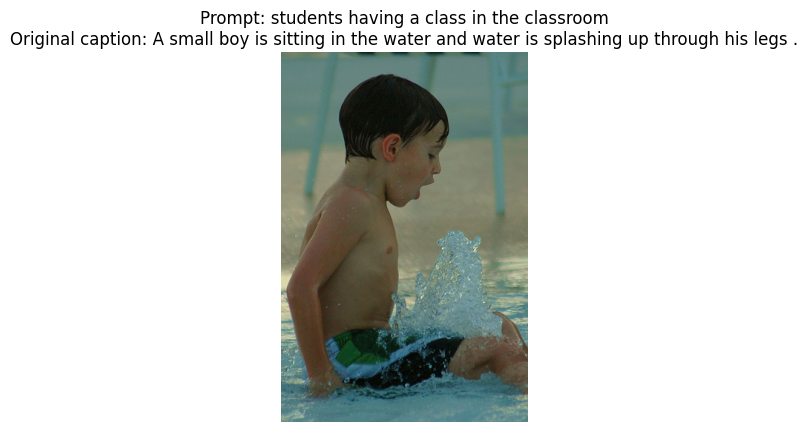

In [34]:
prompt="students having a class in the classroom"
image_folder = r"C:\Users\DHRUV\.cache\kagglehub\datasets\adityajn105\flickr8k\versions\1\Images"
file,cap=match(prompt)                                            
plt.imshow(Image.open(
  rf"{image_folder}/{file}"))
plt.title(f"Prompt: {prompt}\nOriginal caption: {cap}")           
plt.axis("off")
plt.show()

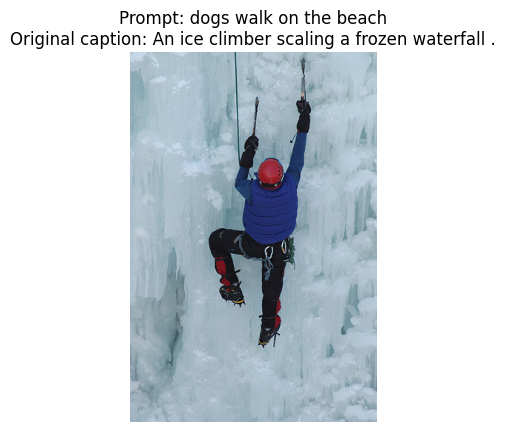

In [41]:
prompt="dogs walk on the beach"
image_folder = r"C:\Users\DHRUV\.cache\kagglehub\datasets\adityajn105\flickr8k\versions\1\Images"
file,cap=match(prompt)                                            
plt.imshow(Image.open(
  rf"{image_folder}/{file}"))
plt.title(f"Prompt: {prompt}\nOriginal caption: {cap}")           
plt.axis("off")
plt.show()